In [142]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import random
import math
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 

In [143]:
from pytrends.request import TrendReq
from pytrends import dailydata

In [144]:
confirmed_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [145]:
dict_data = {}

def load_data(df_str):
    df = pd.read_csv(rf'{df_str}.csv')
    unscaled_col = [col for col in df.columns if 'unscaled' in col][0]
    df.date = df.date.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime('%m/%d/%y'))
    df = df[['date', unscaled_col]]
    return df

def prepare_data(data_dict, cases_data):
    for df_str, df in data_dict.items():
        dates_list = [dat for dat in confirmed_us.date.unique() if dat in df.date.unique()]
        cases_data = cases_data.merge(df[df.date.isin(dates_list)], how='inner', on='date')
    return cases_data

list_str_data = ['fever', 'cough', 'sanitizer', 'mask']       

for str_data in list_str_data:
    dict_data[str_data] = load_data(str_data)

In [146]:
dates_list = [d for d in dict_data['fever'].date.unique() if d in confirmed_cases.T.index]

In [147]:
confirmed_us = confirmed_cases[confirmed_cases['Country/Region'] == 'US'][dates_list].T
confirmed_us.columns = ['Cases']
confirmed_us = confirmed_us.reset_index().rename(columns={'index': 'date'})
dict_cases = {}
for idx in range(1, len(confirmed_us))[::-1]:
    dict_cases[idx] = confirmed_us.loc[idx,:].Cases - confirmed_us.loc[idx-1,:].Cases
dict_cases[0] = 0
confirmed_us['cases_daily'] = confirmed_us.index.map(dict_cases).to_list()
confirmed_us = confirmed_us.drop(index=0).reset_index(drop=True)

In [148]:
final_data = prepare_data(dict_data, confirmed_us.drop('Cases', axis=1))

In [149]:
final_data.head()

,date,cases_daily,Fever_unscaled,Cough_unscaled,Sanitizer_unscaled,mask_unscaled
0,10/11/20,46832,87,81,82,77
1,10/12/20,41732,81,91,95,66
2,10/13/20,51091,75,87,79,70
3,10/14/20,59302,90,91,88,69
4,10/15/20,65114,88,86,100,78


In [150]:
final_data.set_index('date').corr()

,cases_daily,Fever_unscaled,Cough_unscaled,Sanitizer_unscaled,mask_unscaled
cases_daily,1.000000,-0.081721,-0.229427,0.055179,-0.086820
Fever_unscaled,-0.081721,1.000000,0.420358,0.191412,0.202403
Cough_unscaled,-0.229427,0.420358,1.000000,0.290676,0.234069
Sanitizer_unscaled,0.055179,0.191412,0.290676,1.000000,0.284239
mask_unscaled,-0.086820,0.202403,0.234069,0.284239,1.000000


In [151]:
final_data.head()

,date,cases_daily,Fever_unscaled,Cough_unscaled,Sanitizer_unscaled,mask_unscaled
0,10/11/20,46832,87,81,82,77
1,10/12/20,41732,81,91,95,66
2,10/13/20,51091,75,87,79,70
3,10/14/20,59302,90,91,88,69
4,10/15/20,65114,88,86,100,78


In [152]:
dates = final_data.date

In [153]:
total_cases = final_data.cases_daily

In [154]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
total_cases = np.array(total_cases).reshape(-1, 1)

In [155]:
days_in_future = 20
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forecast[:-20]

In [156]:
start = '11/10/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [157]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, total_cases, test_size=0.25, shuffle=False) 

In [158]:
# transform data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forecast = poly.fit_transform(future_forecast)

In [159]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forecast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 3599978.9291083473
MSE: 17848030162259.945


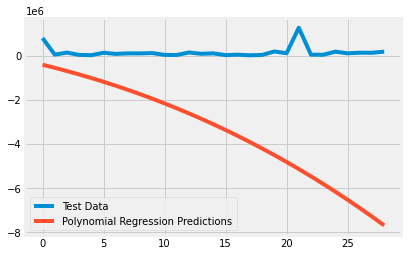

In [160]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [161]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forecast)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MAE: 309210.4914351731
MSE: 178046020739.13132


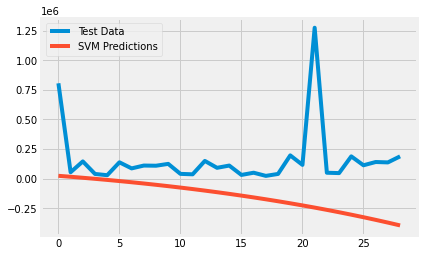

In [162]:
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

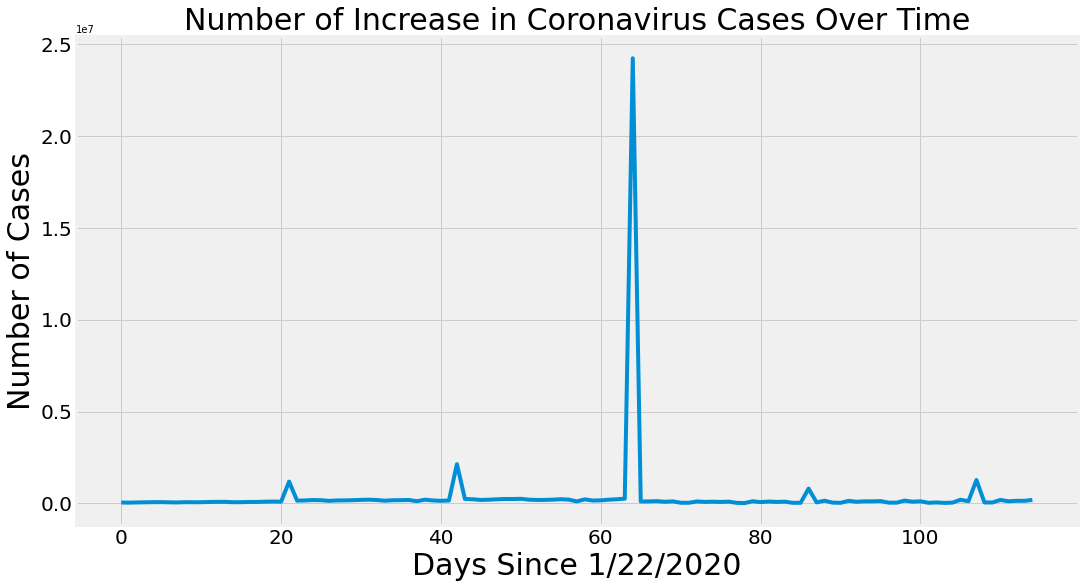

In [163]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_cases)
plt.title('Number of Increase in Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Number of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [164]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
poly_df = pd.DataFrame({'Date': future_forecast_dates[-20:], 'Predicted number of Confirmed Cases Worldwide': np.round(linear_pred[-20:])})
poly_df

,Date,Predicted number of Confirmed Cases Worldwide
0,03/05/2021,-8098876.0
1,03/06/2021,-8522198.0
2,03/07/2021,-8957677.0
3,03/08/2021,-9405469.0
4,03/09/2021,-9865733.0
5,03/10/2021,-10338625.0
6,03/11/2021,-10824304.0
7,03/12/2021,-11322927.0
8,03/13/2021,-11834651.0
9,03/14/2021,-12359634.0


In [165]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forecast_dates[-20:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-20:])})
svm_df

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,03/05/2021,-417558.0
1,03/06/2021,-443125.0
2,03/07/2021,-469590.0
3,03/08/2021,-496975.0
4,03/09/2021,-525304.0
5,03/10/2021,-554602.0
6,03/11/2021,-584892.0
7,03/12/2021,-616201.0
8,03/13/2021,-648553.0
9,03/14/2021,-681975.0


Epoch 1/220
4/4 [==============================] - 1s 7ms/step - loss: 0.1550
Epoch 2/220
4/4 [==============================] - 0s 5ms/step - loss: 0.1416
Epoch 3/220
4/4 [==============================] - 0s 5ms/step - loss: 0.1329
Epoch 4/220
4/4 [==============================] - 0s 5ms/step - loss: 0.1261
Epoch 5/220
4/4 [==============================] - 0s 5ms/step - loss: 0.1203
Epoch 6/220
4/4 [==============================] - 0s 5ms/step - loss: 0.1151
Epoch 7/220
4/4 [==============================] - 0s 5ms/step - loss: 0.1097
Epoch 8/220
4/4 [==============================] - 0s 5ms/step - loss: 0.1054
Epoch 9/220
4/4 [==============================] - 0s 5ms/step - loss: 0.1019
Epoch 10/220
4/4 [==============================] - 0s 5ms/step - loss: 0.0982
Epoch 11/220
4/4 [==============================] - 0s 5ms/step - loss: 0.0944
Epoch 12/220
4/4 [==============================] - 0s 4ms/step - loss: 0.0906
Epoch 13/220
4/4 [==============================] - 0s 5ms/st

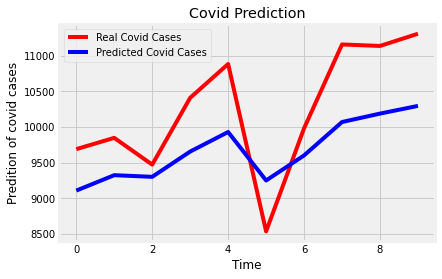

/tmp/ipykernel_149190/414245047.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_next_pred=np.array(list_input[1:])


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [166]:
# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
dataset_train = pd.read_csv('covid_train.csv')
training_set = dataset_train.iloc[:,1:2].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 20 timesteps and t+1 output
X_train = []
y_train = []
for i in range(20, 125):
    X_train.append(training_set_scaled[i-20:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Part 2 - Building the RNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 3,activation='sigmoid',input_shape = (None, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 220, batch_size = 32)

# Joining the train and test dataset under the real no. of covid cases in India
dataset_test = pd.read_csv('covid_test.csv')
test_set = dataset_test.iloc[:,1:2].values
real_covid_cases = np.concatenate((training_set[0:125], test_set), axis = 0)

# Getting the predicted number of cases
scaled_real_covid_cases= sc.fit_transform(real_covid_cases)
inputs = []
for i in range(126, 136):
    inputs.append(scaled_real_covid_cases[i-20:i, 0])
inputs = np.array(inputs)
inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))

predicted_covid_cases = regressor.predict(inputs)

predicted_covid_cases = sc.inverse_transform(predicted_covid_cases)
predicted_covid_cases=predicted_covid_cases.astype('int64')

# Visualising the results
plt.plot(test_set, color = 'red', label = 'Real Covid Cases')
plt.plot(predicted_covid_cases, color = 'blue', label = 'Predicted Covid Cases')
plt.title('Covid Prediction')
plt.xlabel('Time')
plt.ylabel('Predition of covid cases')
plt.legend()
plt.show()

import math
from sklearn.metrics import mean_squared_error
rmse=math.sqrt(mean_squared_error(test_set,predicted_covid_cases))

#predict the next 2 days case
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
real_covid_cases_scaled = sc.fit_transform(real_covid_cases)
input_next_pred=real_covid_cases_scaled.reshape(-1,1)
list_input=list(input_next_pred)
from numpy import array

lst_output=[]
n_steps=135
i=0
while(i<2):
    if(len(list_input)>135):
        input_next_pred=np.array(list_input[1:])
        input_next_pred=input_next_pred.reshape(1,-1)
        input_next_pred = input_next_pred.reshape((1, n_steps, 1))
        y_pred = regressor.predict(input_next_pred, verbose=0)
        y_pred = sc.inverse_transform(y_pred)
        y_pred=y_pred.astype('int64')
        
        list_input.extend(y_pred[0].tolist())
        list_input=list_input[1:]
        lst_output.extend(y_pred.tolist())
        i=i+1
    else:
        input_next_pred= input_next_pred.reshape((1, n_steps,1))
        y_pred = regressor.predict(input_next_pred, verbose=0)
        y_pred = sc.inverse_transform(y_pred)
        y_pred=y_pred.astype('int64')
        list_input.extend(y_pred[0].tolist())
        lst_output.extend(y_pred.tolist())
        i=i+1
    

day_new=np.arange(1,136)
day_pred=np.arange(136,138)
day_new=day_new.reshape(-1,1)

plt.plot(day_new,real_covid_cases,color = 'blue', label = 'Real Covid Cases')
plt.plot(day_pred,lst_output,color = 'green', label = 'Next 2 days cases prediction')
plt.title('Next 2 days covid prediction')
plt.xlabel('Time')
plt.ylabel('Predition of new covid cases')
plt.legend()
plt.show()